<a href="https://colab.research.google.com/github/AruntejaLonka/NYC-Taxi-Trip-Time-Prediction/blob/main/NYC_Taxi_tripi_duriation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install haversine

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV
from haversine import haversine
import statsmodels.formula.api as sm
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import warnings; warnings.simplefilter('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#import the data from a csv file.
data = pd.read_csv("/content/drive/MyDrive/Data sets/NYC Taxi Data (1).csv")

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [ ]:
#Check shape of dataset
data.shape 

(1458644, 11)

In [ ]:
#Check count of unique id's in the dataset
print("There are %d unique id's in Training dataset, which is equal to the number of records"%(data.id.nunique()))

There are 1458644 unique id's in Training dataset, which is equal to the number of records


In [ ]:
#Check for NaN values
data.isnull().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

In [ ]:
#Convert timestamp to datetime format to fetch the other details as listed below
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])
data['dropoff_datetime'] = pd.to_datetime(data['dropoff_datetime'])

In [ ]:
#Calculate and assign new columns to the dataframe such as weekday,
#month and pickup_hour which will help us to gain more insights from the data.
data['weekday'] = data.pickup_datetime.dt.day_name
data['month'] = data.pickup_datetime.dt.month
data['weekday_num'] = data.pickup_datetime.dt.weekday
data['pickup_hour'] = data.pickup_datetime.dt.hour

In [ ]:
#calc_distance is a function to calculate distance between pickup and dropoff coordinates using Haversine formula.
def calc_distance(df):
    pickup = (df['pickup_latitude'], df['pickup_longitude'])
    drop = (df['dropoff_latitude'], df['dropoff_longitude'])
    return haversine(pickup, drop)

In [ ]:
#Calculate distance and assign new column to the dataframe.
data['distance'] = data.apply(lambda x: calc_distance(x), axis = 1)

In [ ]:
#Calculate Speed in km/h for further insights
data['speed'] = (data.distance/(data.trip_duration/3600))


In [ ]:
#Check the type of each variable
data.dtypes.reset_index()

,index,0
0,id,object
1,vendor_id,int64
2,pickup_datetime,datetime64[ns]
3,dropoff_datetime,datetime64[ns]
4,passenger_count,int64
5,pickup_longitude,float64
6,pickup_latitude,float64
7,dropoff_longitude,float64
8,dropoff_latitude,float64
9,store_and_fwd_flag,object


In [ ]:
#Dummify all the categorical features like "store_and_fwd_flag, vendor_id, month, weekday_num, pickup_hour, passenger_count" except the label i.e. "trip_duration"

dummy = pd.get_dummies(data.store_and_fwd_flag, prefix='flag')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.vendor_id, prefix='vendor_id')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.month, prefix='month')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.weekday_num, prefix='weekday_num')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.pickup_hour, prefix='pickup_hour')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

dummy = pd.get_dummies(data.passenger_count, prefix='passenger_count')
dummy.drop(dummy.columns[0], axis=1, inplace=True) #avoid dummy trap
data = pd.concat([data,dummy], axis = 1)

In [ ]:
data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,0,1,0,0,0,0,0,0,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,0,1,0,0,0,0,0,0,0,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,0,1,0,0,0,0,0,0,0,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,0,1,0,0,0,0,0,0,0,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
pd.options.display.float_format = '{:.2f}'.format #To suppres scientific notation.
data.passenger_count.value_counts()

1    1033540
2     210318
5      78088
3      59896
6      48333
4      28404
0         60
7          3
9          1
8          1
Name: passenger_count, dtype: int64

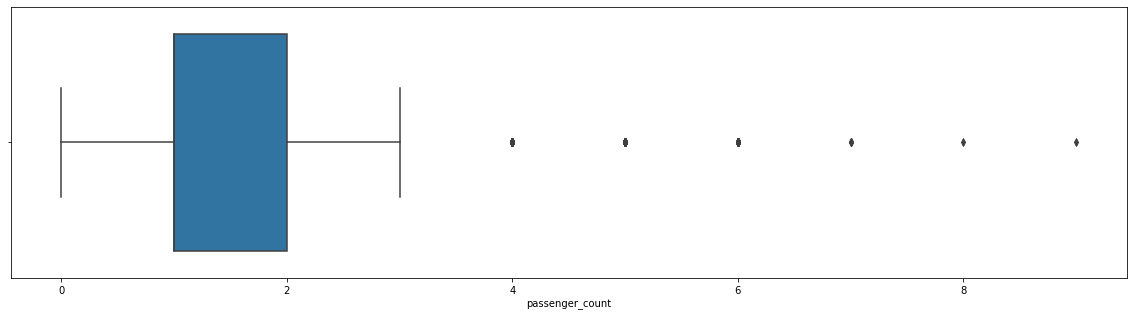

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.passenger_count)
plt.show()

In [ ]:
data.passenger_count.describe()

count   1458644.00
mean          1.66
std           1.31
min           0.00
25%           1.00
50%           1.00
75%           2.00
max           9.00
Name: passenger_count, dtype: float64

In [ ]:
data['passenger_count'] = data.passenger_count.map(lambda x: 1 if x == 0 else x)

In [ ]:
data = data[data.passenger_count <= 6]

In [ ]:
data.passenger_count.value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
Name: passenger_count, dtype: int64

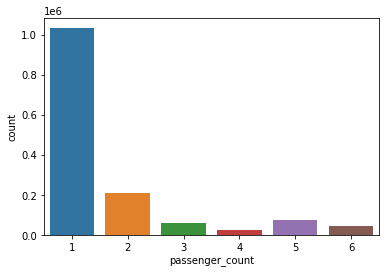

In [ ]:
sns.countplot(data.passenger_count)
plt.show()

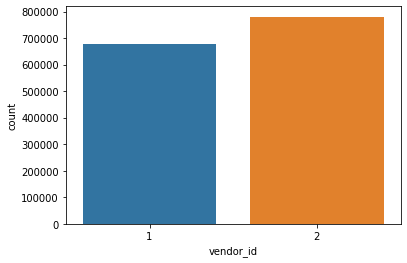

In [ ]:
sns.countplot(data.vendor_id)
plt.show()

In [ ]:
print(data.distance.describe())

count   1458639.00
mean          3.44
std           4.30
min           0.00
25%           1.23
50%           2.09
75%           3.88
max        1240.91
Name: distance, dtype: float64


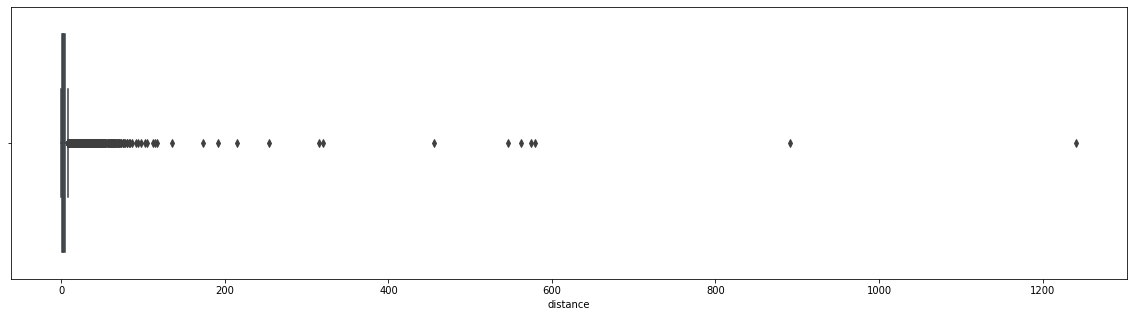

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.distance)
plt.show()


In [ ]:
print("There are {} trip records with 0 km distance".format(data.distance[data.distance == 0 ].count()))

There are 5895 trip records with 0 km distance


In [ ]:
data[data.distance == 0 ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
246,id3487442,2,2016-02-29 18:39:12,2016-02-29 18:42:59,1,-73.98,40.77,-73.98,40.77,N,...,0,1,0,0,0,0,0,0,0,0
291,id0924324,2,2016-05-10 18:07:52,2016-05-10 18:26:21,2,-73.96,40.78,-73.96,40.78,N,...,0,0,1,0,0,0,0,0,0,0
407,id1145809,2,2016-05-16 23:15:13,2016-05-16 23:31:00,6,-73.81,40.69,-73.81,40.69,N,...,1,0,0,0,0,0,1,0,0,0
702,id3499387,1,2016-01-25 19:45:12,2016-01-25 19:54:52,1,-73.79,40.65,-73.79,40.65,N,...,0,1,0,0,0,0,0,0,0,0
1620,id0753277,1,2016-01-27 22:29:31,2016-01-27 22:29:58,1,-74.21,40.82,-74.21,40.82,N,...,0,1,0,0,0,0,0,0,0,0


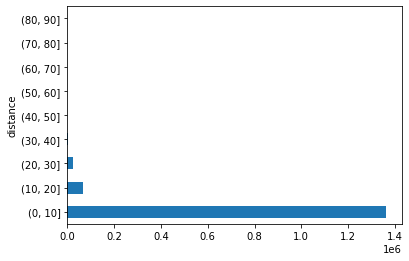

In [ ]:
data.distance.groupby(pd.cut(data.distance, np.arange(0,100,10))).count().plot(kind='barh')
plt.show()

In [ ]:
data.trip_duration.describe()

count   1458639.00
mean        959.50
std        5237.44
min           1.00
25%         397.00
50%         662.00
75%        1075.00
max     3526282.00
Name: trip_duration, dtype: float64

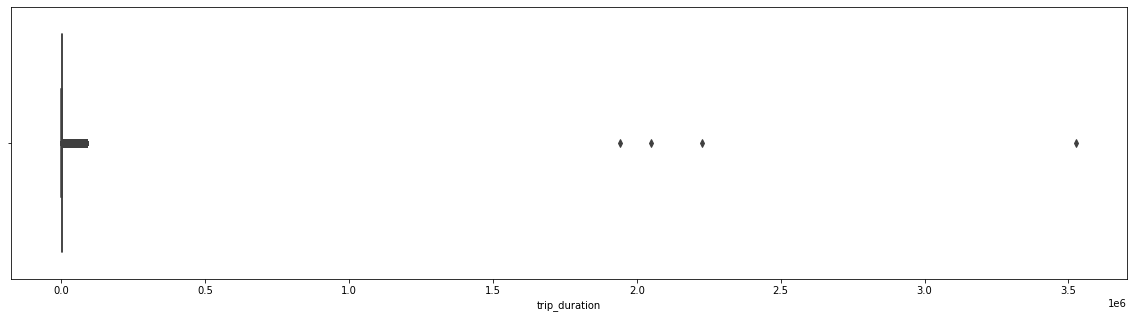

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.trip_duration)
plt.show()

In [ ]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,max(data.trip_duration),3600))).count()

trip_duration
(1, 3601]             1446308
(3601, 7201]            10045
(7201, 10801]             141
(10801, 14401]             35
(14401, 18001]              5
                       ...   
(3506401, 3510001]          0
(3510001, 3513601]          0
(3513601, 3517201]          0
(3517201, 3520801]          0
(3520801, 3524401]          0
Name: trip_duration, Length: 979, dtype: int64

In [ ]:
data[data.trip_duration > 86400]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.79,40.64,-73.96,40.77,N,...,0,1,0,0,0,0,0,0,0,0
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.92,40.74,-73.98,40.76,N,...,0,0,1,0,0,0,0,0,0,0
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.98,40.74,-73.99,40.73,N,...,0,1,0,0,0,0,0,0,0,0
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.78,40.65,-73.98,40.75,N,...,0,1,0,0,0,0,0,0,0,0


In [ ]:
data = data[data.trip_duration <= 86400]

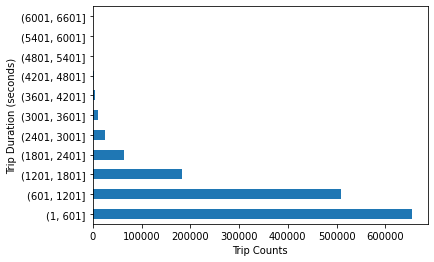

In [ ]:
data.trip_duration.groupby(pd.cut(data.trip_duration, np.arange(1,7200,600))).count().plot(kind='barh')
plt.xlabel('Trip Counts')
plt.ylabel('Trip Duration (seconds)')
plt.show()

In [ ]:
data.speed.describe()

count   1458635.00
mean         14.42
std          14.98
min           0.00
25%           9.12
50%          12.79
75%          17.84
max        9274.85
Name: speed, dtype: float64

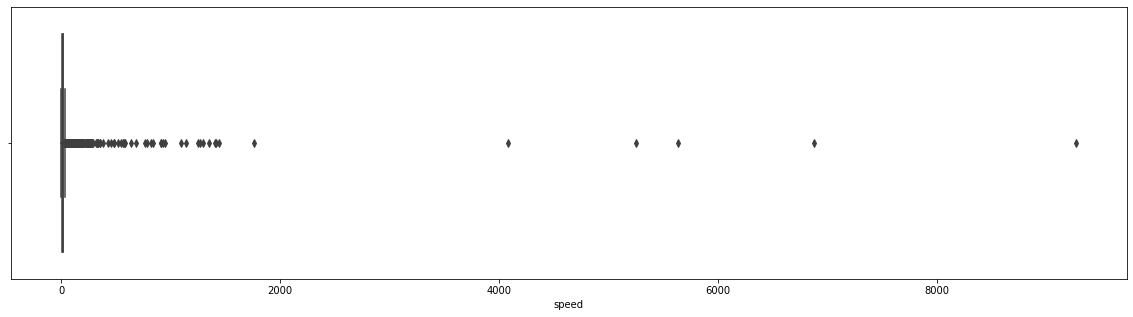

In [ ]:
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

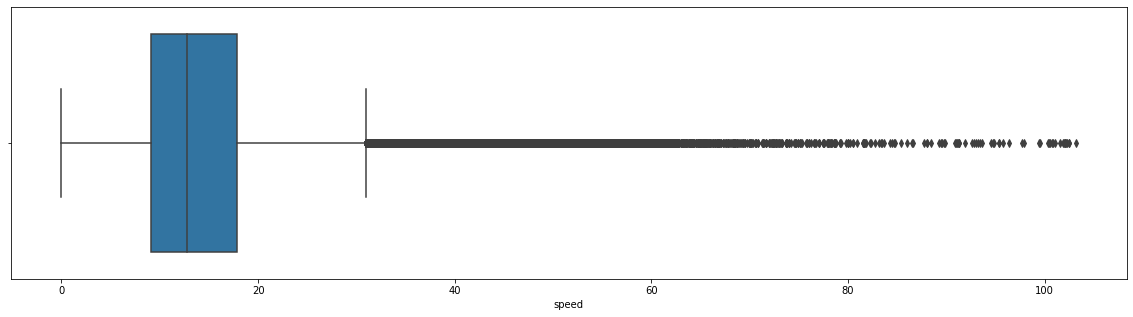

In [ ]:
data = data[data.speed <= 104]
plt.figure(figsize = (20,5))
sns.boxplot(data.speed)
plt.show()

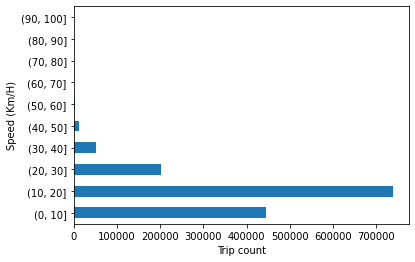

In [ ]:
data.speed.groupby(pd.cut(data.speed, np.arange(0,104,10))).count().plot(kind = 'barh')
plt.xlabel('Trip count')
plt.ylabel('Speed (Km/H)')
plt.show()

In [ ]:
data.flag_Y.value_counts(normalize=True)

0   0.99
1   0.01
Name: flag_Y, dtype: float64

In [ ]:
data.flag_Y.value_counts()

0    1450433
1       8044
Name: flag_Y, dtype: int64

In [ ]:
data.vendor_id[data.flag_Y == 1].value_counts()

1    8044
Name: vendor_id, dtype: int64

In [ ]:
data[data.flag_Y == 1]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
348,id1633648,1,2016-06-20 14:19:16,2016-06-20 14:34:34,1,-73.98,40.75,-73.95,40.77,Y,...,0,1,0,0,0,0,0,0,0,0
491,id2042535,1,2016-02-12 12:36:38,2016-02-12 12:47:07,1,-73.98,40.76,-73.99,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
610,id0909228,1,2016-05-08 15:02:28,2016-05-08 15:17:54,1,-73.99,40.74,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0
774,id3697489,1,2016-01-13 13:53:29,2016-01-13 14:08:21,1,-73.95,40.78,-73.98,40.78,Y,...,0,1,0,0,0,0,0,0,0,0
846,id1026973,1,2016-06-25 21:53:30,2016-06-25 22:05:27,1,-73.98,40.76,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457556,id2229555,1,2016-01-22 19:05:50,2016-01-22 19:27:09,1,-73.87,40.77,-73.93,40.73,Y,...,0,1,0,0,0,0,0,0,0,0
1457670,id0510811,1,2016-04-07 21:14:30,2016-04-07 21:51:38,1,-73.78,40.64,-73.98,40.67,Y,...,0,1,0,0,0,0,0,0,0,0
1457897,id3209015,1,2016-03-20 18:49:55,2016-03-20 19:09:25,1,-73.99,40.71,-74.00,40.75,Y,...,0,1,0,0,0,0,0,0,0,0
1458060,id1371896,1,2016-03-28 11:45:49,2016-03-28 12:21:45,1,-73.97,40.76,-74.01,40.72,Y,...,0,1,0,0,0,0,0,0,0,0


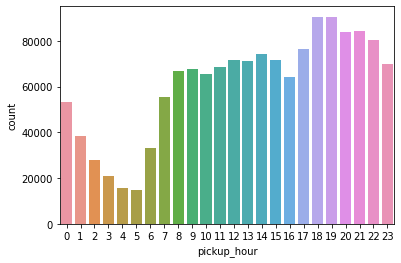

In [ ]:
sns.countplot(data.pickup_hour)
plt.show()

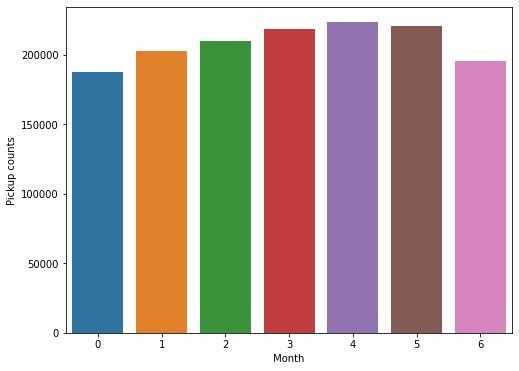

In [ ]:
plt.figure(figsize = (8,6))
sns.countplot(data.weekday_num)
plt.xlabel(' Month ')
plt.ylabel('Pickup counts')
plt.show()

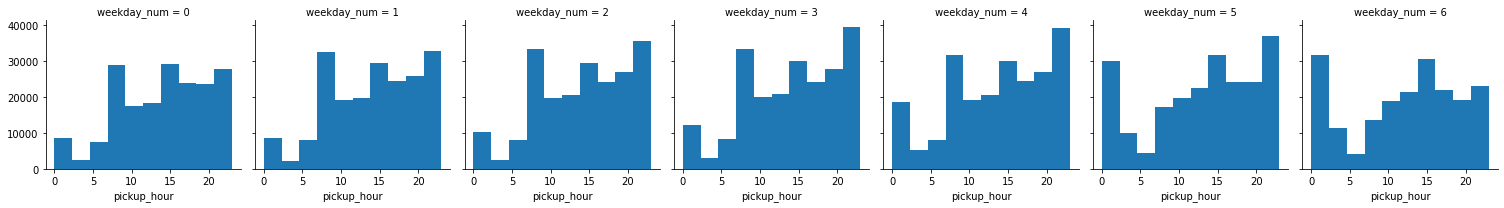

In [ ]:
n = sns.FacetGrid(data, col='weekday_num')
n.map(plt.hist, 'pickup_hour')
plt.show()

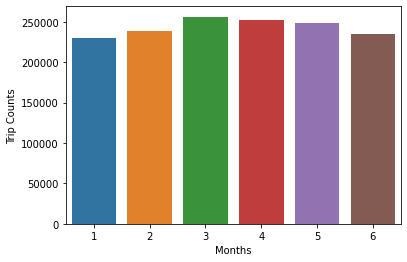

In [ ]:
sns.countplot(data.month)
plt.ylabel('Trip Counts')
plt.xlabel('Months')
plt.show()

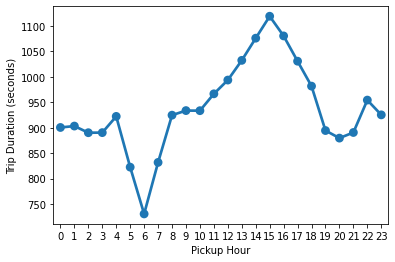

In [ ]:
group1 = data.groupby('pickup_hour').trip_duration.mean()
sns.pointplot(group1.index, group1.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Pickup Hour')
plt.show()

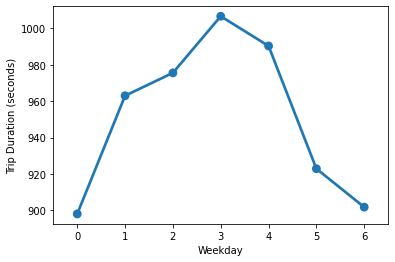

In [ ]:
group2 = data.groupby('weekday_num').trip_duration.mean()
sns.pointplot(group2.index, group2.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Weekday')
plt.show()

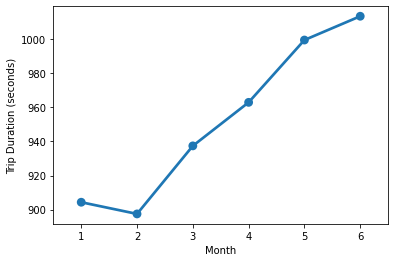

In [ ]:
group3 = data.groupby('month').trip_duration.mean()
sns.pointplot(group3.index, group3.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Month')
plt.show()

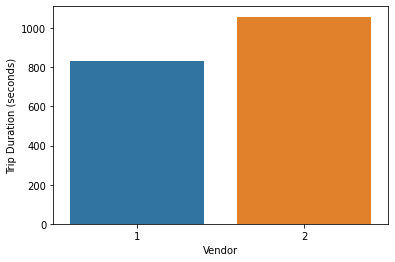

In [ ]:
group4 = data.groupby('vendor_id').trip_duration.mean()
sns.barplot(group4.index, group4.values)
plt.ylabel('Trip Duration (seconds)')
plt.xlabel('Vendor')
plt.show()

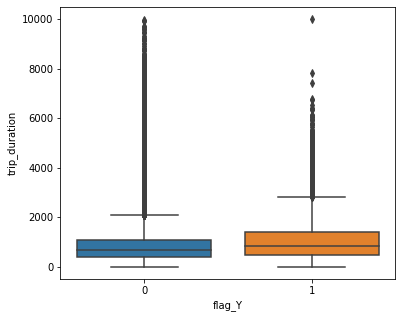

In [ ]:
plt.figure(figsize = (6,5))
plot_dur = data.loc[(data.trip_duration < 10000)]
sns.boxplot(x = "flag_Y", y = "trip_duration", data = plot_dur)
plt.show()

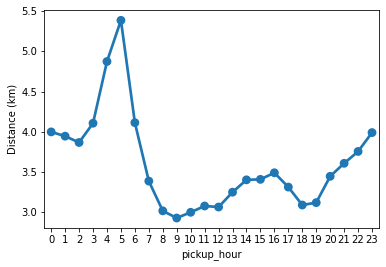

In [ ]:
group5 = data.groupby('pickup_hour').distance.mean()
sns.pointplot(group5.index, group5.values)
plt.ylabel('Distance (km)')
plt.show()

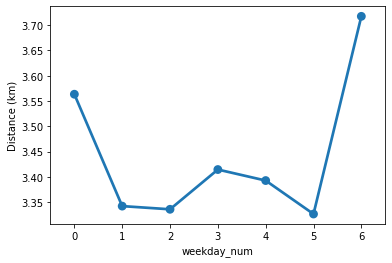

In [ ]:
group6 = data.groupby('weekday_num').distance.mean()
sns.pointplot(group6.index, group6.values)
plt.ylabel('Distance (km)')
plt.show()

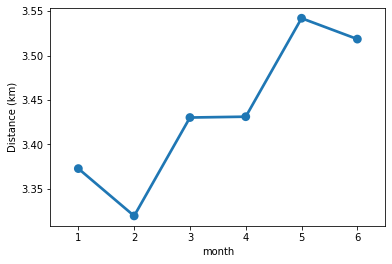

In [ ]:
group7 = data.groupby('month').distance.mean()
sns.pointplot(group7.index, group7.values)
plt.ylabel('Distance (km)')
plt.show()

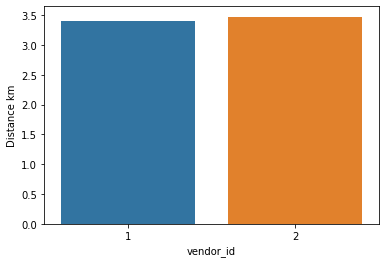

In [ ]:
group8 = data.groupby('vendor_id').distance.mean()
sns.barplot(group8.index, group8.values)
plt.ylabel("Distance km")
plt.show()

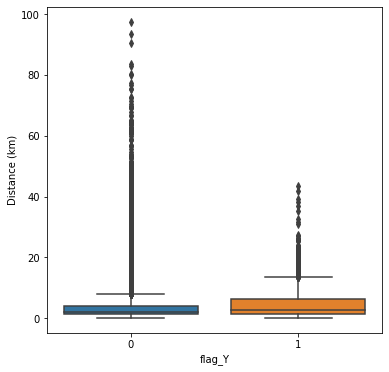

In [ ]:
plt.figure(figsize = (6,6))
plot_dist = data.loc[(data.distance < 100)]
sns.boxplot(x = "flag_Y", y = "distance", data = plot_dist)
plt.ylabel('Distance (km)')
plt.show()

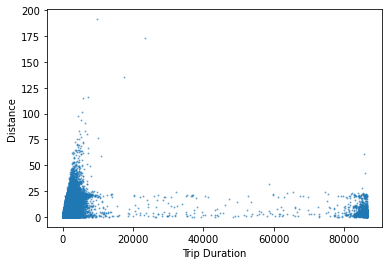

In [ ]:
plt.scatter(data.trip_duration, data.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

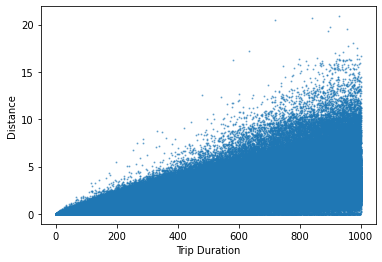

In [ ]:
dur_dist = data.loc[(data.distance < 50) & (data.trip_duration < 1000), ['distance','trip_duration']]
plt.scatter(dur_dist.trip_duration, dur_dist.distance , s=1, alpha=0.5)
plt.ylabel('Distance')
plt.xlabel('Trip Duration')
plt.show()

In [ ]:
data = data[~((data.distance == 0) & (data.trip_duration >= 60))]

In [ ]:
duo = data.loc[(data['distance'] <= 1) & (data['trip_duration'] >= 3600),['distance','trip_duration']].reset_index(drop=True)

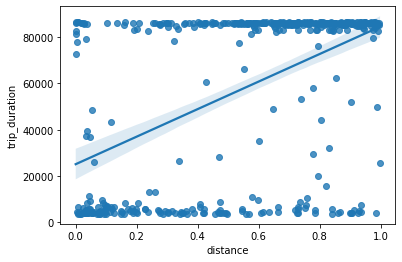

In [ ]:
sns.regplot(duo.distance, duo.trip_duration)
plt.show()

In [ ]:
data = data[~((data['distance'] <= 1) & (data['trip_duration'] >= 3600))]

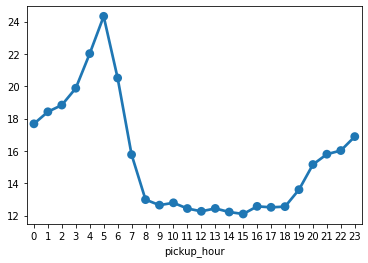

In [ ]:
group9 = data.groupby('pickup_hour').speed.mean()
sns.pointplot(group9.index, group9.values)
plt.show()

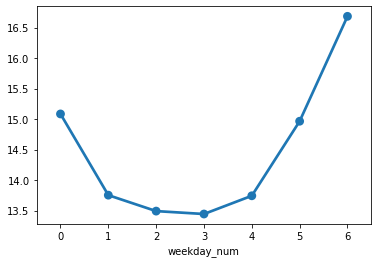

In [ ]:
group10 = data.groupby('weekday_num').speed.mean()
sns.pointplot(group10.index, group10.values)
plt.show()


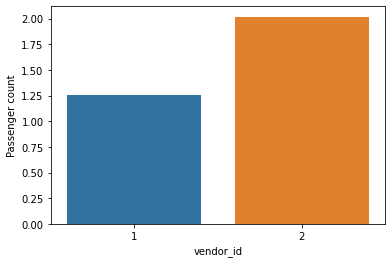

In [ ]:
group9 = data.groupby('vendor_id').passenger_count.mean()
sns.barplot(group9.index, group9.values)
plt.ylabel('Passenger count')
plt.show()

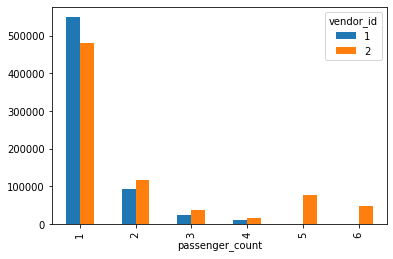

In [ ]:
data.groupby('passenger_count').vendor_id.value_counts().reset_index(name='count').pivot("passenger_count","vendor_id","count").plot(kind='bar')
plt.show()

In [ ]:
!pip install basemap

In [ ]:
def map_marker(set):
    # Import package for map
    from mpl_toolkits.basemap import Basemap
    plt.figure(figsize = (20,20))

    # Set the limits of the map to the minimum and maximum coordinates
    lat_min = data["pickup_latitude"].min() - .2
    lat_max = data["pickup_latitude"].max() + .2
    lon_min = data["pickup_longitude"].min() - .2
    lon_max = data["pickup_longitude"].max() + .2

    # Set the center of the map
    cent_lat = (lat_min + lat_max) / 2
    cent_lon = (lon_min + lon_max) / 2

    #Create the Basemap object with required params.
    map = Basemap(llcrnrlon=lon_min,
                  llcrnrlat=lat_min,
                  urcrnrlon=lon_max,
                  urcrnrlat=lat_max,
                  resolution='l',
                  projection='tmerc',
                  lat_0 = cent_lat,
                  lon_0 = cent_lon)

    #Style the map
    map.drawmapboundary()
    map.drawcoastlines()
    map.fillcontinents()
    map.drawcountries(linewidth=2)
    map.drawstates()


    #Fetch the long and lat in form of array
    long = np.array(data["pickup_longitude"])
    lat = np.array(data["pickup_latitude"])

    x, y = map(long, lat)
    map.plot(x, y,'ro', markersize=2, alpha=1)

    plt.show()

In [ ]:
#CA state pickup
data[data.pickup_longitude == data.pickup_longitude.min()]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_hour_23,passenger_count_1,passenger_count_2,passenger_count_3,passenger_count_4,passenger_count_5,passenger_count_6,passenger_count_7,passenger_count_8,passenger_count_9
1184454,id2854272,2,2016-02-26 13:50:19,2016-02-26 13:58:38,2,-121.93,37.39,-121.93,37.39,N,...,0,0,1,0,0,0,0,0,0,0


In [ ]:
data = data[data.pickup_longitude != data.pickup_longitude.min()]

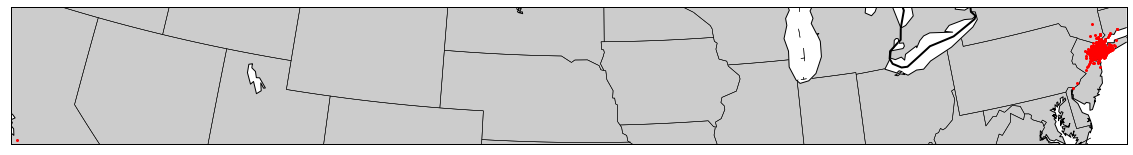

In [ ]:
map_marker(data)

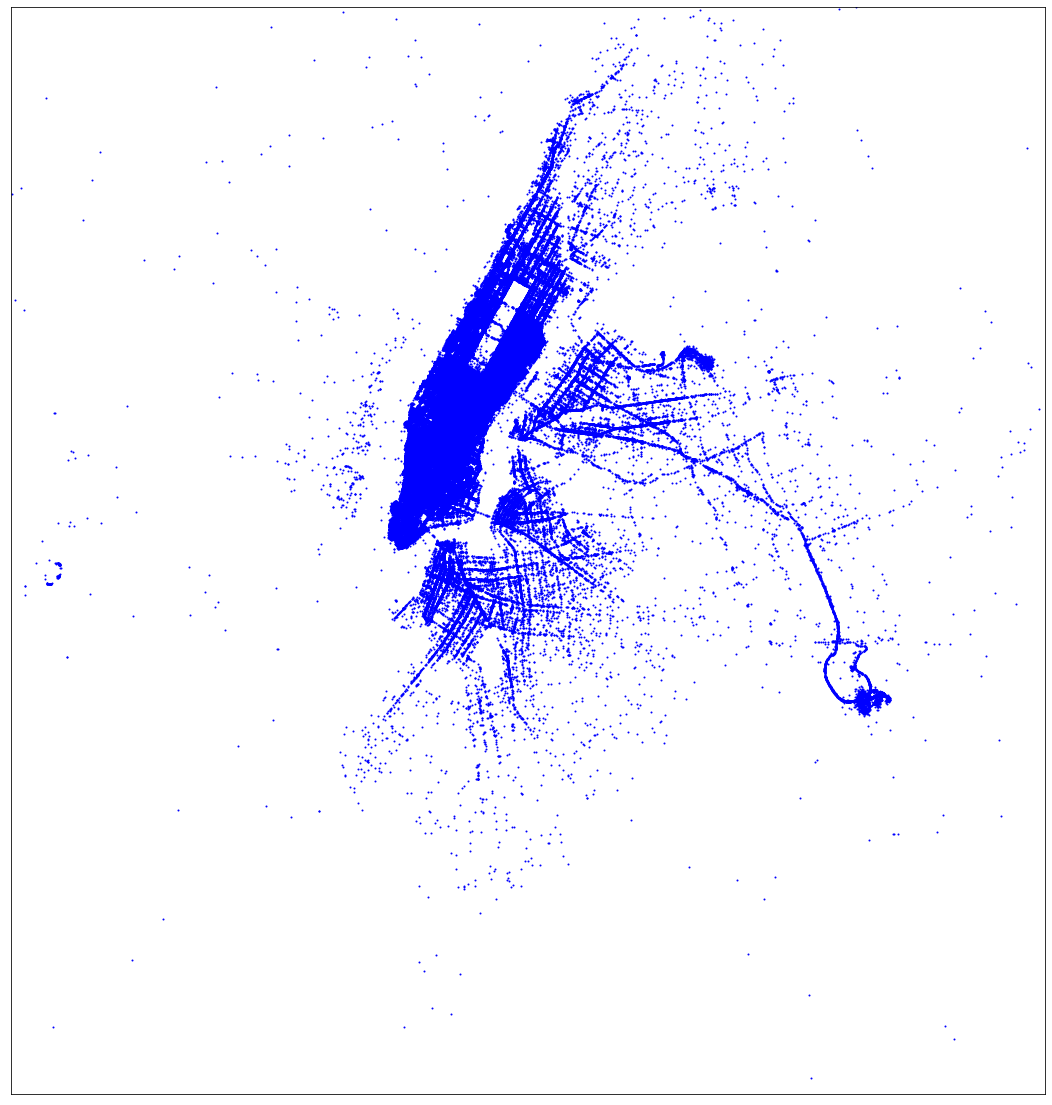

In [ ]:
plt.figure(figsize=(20,20))
from mpl_toolkits.basemap import Basemap

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
              llcrnrlat=lat_min,
              urcrnrlon=lon_max,
              urcrnrlat=lat_max,
              resolution='l',
              projection='tmerc',
              lat_0 = cent_lat,
              lon_0 = cent_lon)

#Style the map
# map.drawcounties()

#Fetch the long and lat in form of array
long = np.array(data["pickup_longitude"])
lat = np.array(data["pickup_latitude"])

x, y = map(long, lat)
map.plot(x, y,'bo', markersize=1, alpha=1)
plt.xticks()
plt.show()

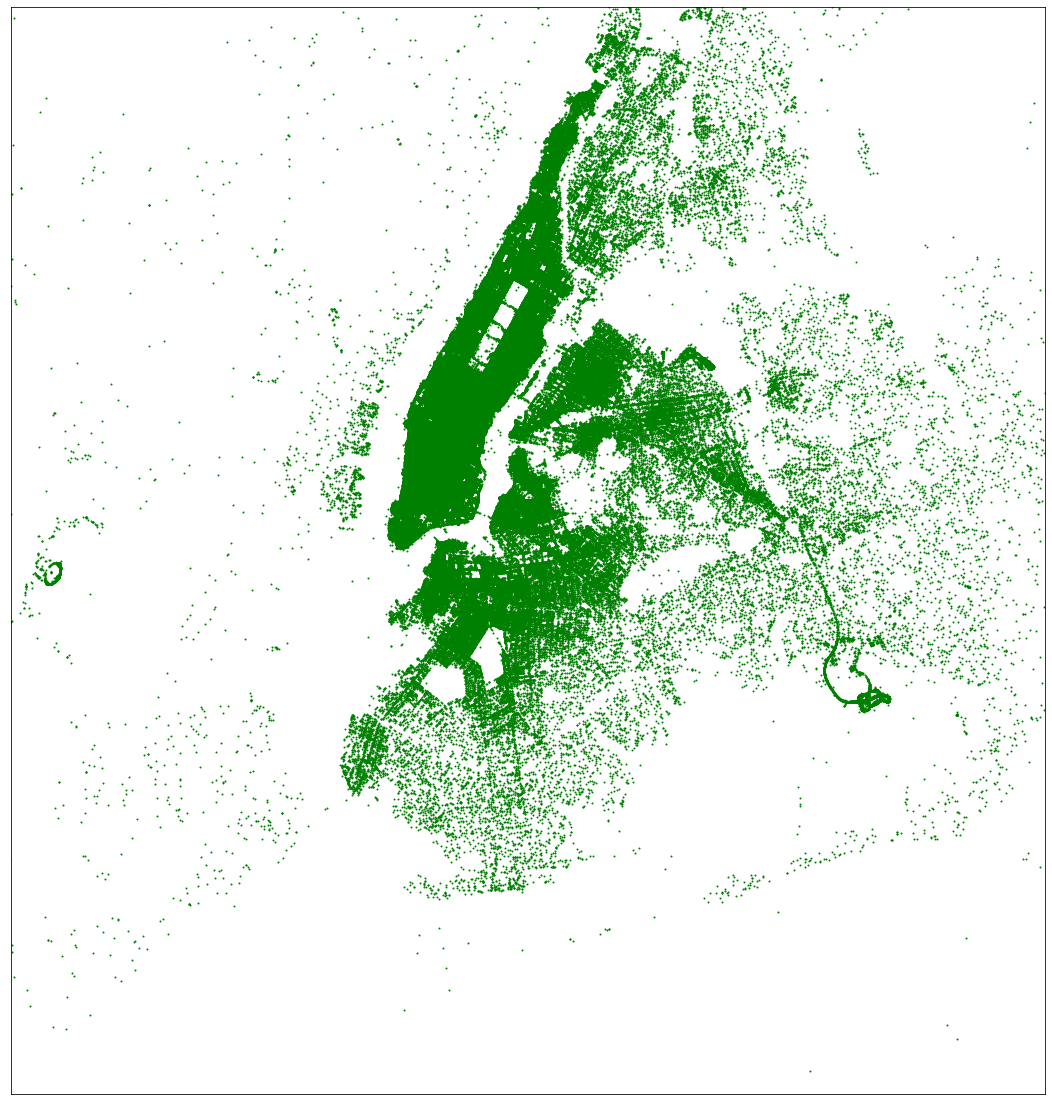

In [ ]:
plt.figure(figsize=(20,20))

# Set the limits of the map to the minimum and maximum coordinates
lat_min = 40.5
lat_max = 40.9
lon_min = -74.2
lon_max = -73.7

# Set the center of the map
cent_lat = (lat_min + lat_max) / 2
cent_lon = (lon_min + lon_max) / 2

#Create the Basemap object with required params.
map = Basemap(llcrnrlon=lon_min,
              llcrnrlat=lat_min,
              urcrnrlon=lon_max,
              urcrnrlat=lat_max,
              resolution='l',
              projection='tmerc',
              lat_0 = cent_lat,
              lon_0 = cent_lon)

#Style the map
# map.drawcounties()

#Fetch the long and lat in form of array
long = np.array(data["dropoff_longitude"])
lat = np.array(data["dropoff_latitude"])

x, y = map(long, lat)
map.plot(x, y,'go', markersize=1, alpha=1)
plt.xticks()
plt.show()

In [ ]:
#First chech the index of the features and label
list(zip( range(0,len(data.columns)),data.columns))

[(0, 'id'),
 (1, 'vendor_id'),
 (2, 'pickup_datetime'),
 (3, 'dropoff_datetime'),
 (4, 'passenger_count'),
 (5, 'pickup_longitude'),
 (6, 'pickup_latitude'),
 (7, 'dropoff_longitude'),
 (8, 'dropoff_latitude'),
 (9, 'store_and_fwd_flag'),
 (10, 'trip_duration'),
 (11, 'weekday'),
 (12, 'month'),
 (13, 'weekday_num'),
 (14, 'pickup_hour'),
 (15, 'distance'),
 (16, 'speed'),
 (17, 'flag_Y'),
 (18, 'vendor_id_2'),
 (19, 'month_2'),
 (20, 'month_3'),
 (21, 'month_4'),
 (22, 'month_5'),
 (23, 'month_6'),
 (24, 'weekday_num_1'),
 (25, 'weekday_num_2'),
 (26, 'weekday_num_3'),
 (27, 'weekday_num_4'),
 (28, 'weekday_num_5'),
 (29, 'weekday_num_6'),
 (30, 'pickup_hour_1'),
 (31, 'pickup_hour_2'),
 (32, 'pickup_hour_3'),
 (33, 'pickup_hour_4'),
 (34, 'pickup_hour_5'),
 (35, 'pickup_hour_6'),
 (36, 'pickup_hour_7'),
 (37, 'pickup_hour_8'),
 (38, 'pickup_hour_9'),
 (39, 'pickup_hour_10'),
 (40, 'pickup_hour_11'),
 (41, 'pickup_hour_12'),
 (42, 'pickup_hour_13'),
 (43, 'pickup_hour_14'),
 (44, 'pic

In [ ]:
Y = data.iloc[:,10].values
X = data.iloc[:,range(15,61)].values

In [ ]:
print("Let's append {} rows of 1's as the first column in the X array".format(X.shape[0]))

Let's append 1453810 rows of 1's as the first column in the X array


In [ ]:
X1 = np.append(arr = np.ones((X.shape[0],1)).astype(int), values = X, axis = 1)

In [ ]:
X1.shape

(1453810, 47)

In [ ]:
import statsmodels.formula.api as sm
import statsmodels.regression.linear_model as sm1

In [ ]:
X_opt = X1[:,[0,1,3,4,6,7,8,9,10,11]]
regressor_OLS = sm1.OLS(endog = Y, exog = X_opt).fit()
regressor_OLS.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.034
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     5767.
Date:                Sun, 03 Apr 2022   Prob (F-statistic):               0.00
Time:                        09:23:56   Log-Likelihood:            -1.3648e+07
No. Observations:             1453810   AIC:                         2.730e+07
Df Residuals:                 1453800   BIC:                         2.730e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        318.6789      5.554     57.379      0.000     307.793     329.564
x1           135.3479      0.607    223.150      0.000     134.159     136.537
x2            38.7214     32.484      1.192      0.233     -24.946     102.389
x3           185.9133      4.821     38.564      0.000     176.465     195.362
x4            22.3395      7.119      3.138      0.002       8.387      36.292
x5            50.1026      7.156      7.001      0.000      36.077      64.129
x6            77.3140      7.189     10.755      0.000      63.224      91.404
x7            89.1815      7.331     12.165      0.000      74.813     103.550
x8            31.5191      7.030      4.483      0.000      17.740      45.298
x9            46.7794      6.927      6.753      0.000      33.202      60.356
==============================================================================
Omnibus:                  3656015.284   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      40753661166.328
Skew:                          28.273   Prob(JB):                         0.00
Kurtosis:                     821.277   Cond. No.                         71.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [ ]:
#Select all the features in X array
X_opt = X1[:,range(0,46)]
regressor_OLS = sm1.OLS(endog = Y, exog = X_opt).fit()

#Fetch p values for each feature
p_Vals = regressor_OLS.pvalues

#define significance level for accepting the feature.
sig_Level = 0.05

#Loop to iterate over features and remove the feature with p value less than the sig_level
while max(p_Vals) > sig_Level:
    print("Probability values of each feature \n")
    print(p_Vals)
    X_opt = np.delete(X_opt, np.argmax(p_Vals), axis = 1)
    print("\n")
    print("Feature at index {} is removed \n".format(str(np.argmax(p_Vals))))
    print(str(X_opt.shape[1]-1) + " dimensions remaining now... \n")
    regressor_OLS = sm1.OLS(endog = Y, exog = X_opt).fit()
    p_Vals = regressor_OLS.pvalues
    print("=================================================================\n")
    
#Print final summary
print("Final stat summary with optimal {} features".format(str(X_opt.shape[1]-1)))
regressor_OLS.summary()

Probability values of each feature 

[1.25387548e-001 0.00000000e+000 0.00000000e+000 5.69458190e-001
 1.92250752e-305 2.61675159e-001 3.80030287e-001 7.81237094e-001
 1.08695701e-001 3.30531668e-002 4.64189222e-001 8.08662648e-002
 3.44786587e-001 8.44370066e-001 2.41873455e-005 1.87734582e-018
 2.09139673e-003 7.20766034e-008 1.46485132e-011 7.60754196e-016
 3.14623335e-016 2.10971030e-005 1.71386113e-004 5.78296060e-017
 1.57397954e-017 4.41637180e-020 5.75433875e-026 3.87814139e-020
 3.27086167e-019 4.28403030e-022 2.52519554e-016 2.54122804e-016
 6.36948007e-021 2.74639996e-021 4.15963418e-022 3.13841122e-010
 1.25077181e-004 3.19093552e-001 6.38983962e-002 3.12073908e-002
 3.51639152e-002 3.12976406e-002 2.99086566e-002 2.98881378e-002
 2.95806710e-002             nan]


Feature at index 45 is removed 

44 dimensions remaining now... 


Probability values of each feature 

[1.25387548e-001 0.00000000e+000 0.00000000e+000 5.69458190e-001
 1.92250752e-305 2.61675159e-001 3.80030287

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.153
Model:                            OLS   Adj. R-squared (uncentered):              0.153
Method:                 Least Squares   F-statistic:                              7745.
Date:                Sun, 03 Apr 2022   Prob (F-statistic):                        0.00
Time:                        09:25:59   Log-Likelihood:                     -1.3623e+07
No. Observations:             1453810   AIC:                                  2.725e+07
Df Residuals:                 1453776   BIC:                                  2.725e+07
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           228.6199      0.726    314.845      0.000     227.197     230.043
x2           -87.4719      0.394   -222.050      0.000     -88.244     -86.700
x3           185.7237      4.948     37.531      0.000     176.025     195.423
x4            14.3760      6.398      2.247      0.025       1.835      26.917
x5            18.4682      6.553      2.818      0.005       5.625      31.311
x6            44.8034      6.759      6.629      0.000      31.557      58.050
x7            88.8908      7.190     12.364      0.000      74.799     102.982
x8            75.6038     15.858      4.768      0.000      44.523     106.685
x9           130.0915     18.213      7.143      0.000      94.394     165.789
x10          173.9876     20.754      8.383      0.000     133.311     214.665
x11          225.1716     23.584      9.548      0.000     178.948     271.395
x12          232.6898     24.190      9.619      0.000     185.279     280.100
x13          101.8360     16.923      6.017      0.000      68.667     135.005
x14          -48.4035     13.662     -3.543      0.000     -75.180     -21.627
x15         -122.5366     12.760     -9.603      0.000    -147.546     -97.527
x16         -124.6337     12.709     -9.806      0.000    -149.544     -99.724
x17         -136.4262     12.857    -10.611      0.000    -161.626    -111.227
x18         -157.5288     12.658    -12.445      0.000    -182.338    -132.720
x19         -133.6877     12.441    -10.746      0.000    -158.072    -109.304
x20         -130.0469     12.463    -10.435      0.000    -154.474    -105.620
x21         -140.3993     12.304    -11.411      0.000    -164.514    -116.284
x22         -117.4335     12.462     -9.423      0.000    -141.859     -93.008
x23         -120.4583     12.961     -9.294      0.000    -145.862     -95.055
x24         -134.7743     12.158    -11.086      0.000    -158.603    -110.946
x25         -131.3003     11.452    -11.465      0.000    -153.746    -108.855
x26         -134.1594     11.424    -11.744      0.000    -156.549    -111.770
x27          -82.6736     11.679     -7.079      0.000    -105.564     -59.783
x28          -43.8672     11.667     -3.760      0.000     -66.733     -21.001
x29         1362.0430      9.098    149.709      0.000    1344.211    1379.875
x30         1344.1915     10.670    125.977      0.000    1323.278    1365.105
x31         1362.1047     14.564     93.523      0.000    1333.559    1390.650
x32         1369.4202     18.980     72.151      0.000    1332.220    1406.620
x33         1368.7516     14.031     97.549      0.000    1341.251    1396.253
x34         1370.4611     16.195     84.623      0.000    1338.720    1402.203
=============================================================

In [ ]:
#Split raw data
X_train, X_test, y_train, y_test = train_test_split(X,Y, random_state=4, test_size=0.2)

#Split data from the feature selection group
X_train_fs, X_test_fs, y_train_fs, y_test_fs = train_test_split(X_opt,Y, random_state=4, test_size=0.2)

In [ ]:
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X,Y, random_state=4, test_size=0.2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_pca = scaler.fit_transform(X_train_pca)
X_test_pca = scaler.transform(X_test_pca)

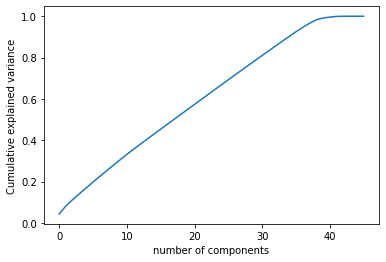

In [ ]:
from sklearn.decomposition import PCA
pca = PCA().fit(X_train_pca)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("Cumulative explained variance")
plt.show()

In [ ]:
arr = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
list(zip(range(1,len(arr)), arr))

[(1, 4.32),
 (2, 8.26),
 (3, 11.29),
 (4, 14.149999999999999),
 (5, 16.979999999999997),
 (6, 19.759999999999998),
 (7, 22.509999999999998),
 (8, 25.229999999999997),
 (9, 27.9),
 (10, 30.56),
 (11, 33.14),
 (12, 35.71),
 (13, 38.13),
 (14, 40.550000000000004),
 (15, 42.970000000000006),
 (16, 45.38000000000001),
 (17, 47.790000000000006),
 (18, 50.190000000000005),
 (19, 52.59),
 (20, 54.980000000000004),
 (21, 57.370000000000005),
 (22, 59.760000000000005),
 (23, 62.14000000000001),
 (24, 64.52000000000001),
 (25, 66.9),
 (26, 69.28),
 (27, 71.65),
 (28, 74.01),
 (29, 76.37),
 (30, 78.7),
 (31, 81.03),
 (32, 83.35),
 (33, 85.66),
 (34, 87.97),
 (35, 90.27),
 (36, 92.53),
 (37, 94.64),
 (38, 96.58),
 (39, 98.28999999999999),
 (40, 99.16),
 (41, 99.59),
 (42, 99.93),
 (43, 100.02000000000001),
 (44, 100.02000000000001),
 (45, 100.02000000000001)]

In [ ]:
pca_10 = PCA(n_components=40)
X_train_pca = pca_10.fit_transform(X_train_pca)
X_test_pca = pca_10.transform(X_test_pca)

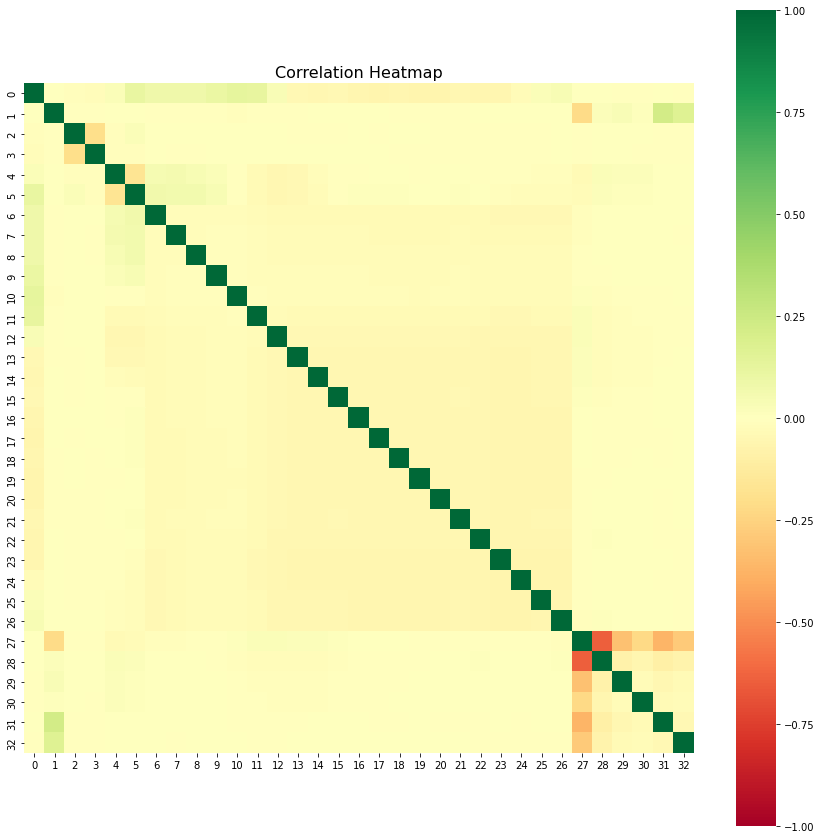

In [ ]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_fs[:,1:]).corr()
corr.index = pd.DataFrame(X_train_fs[:,1:]).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

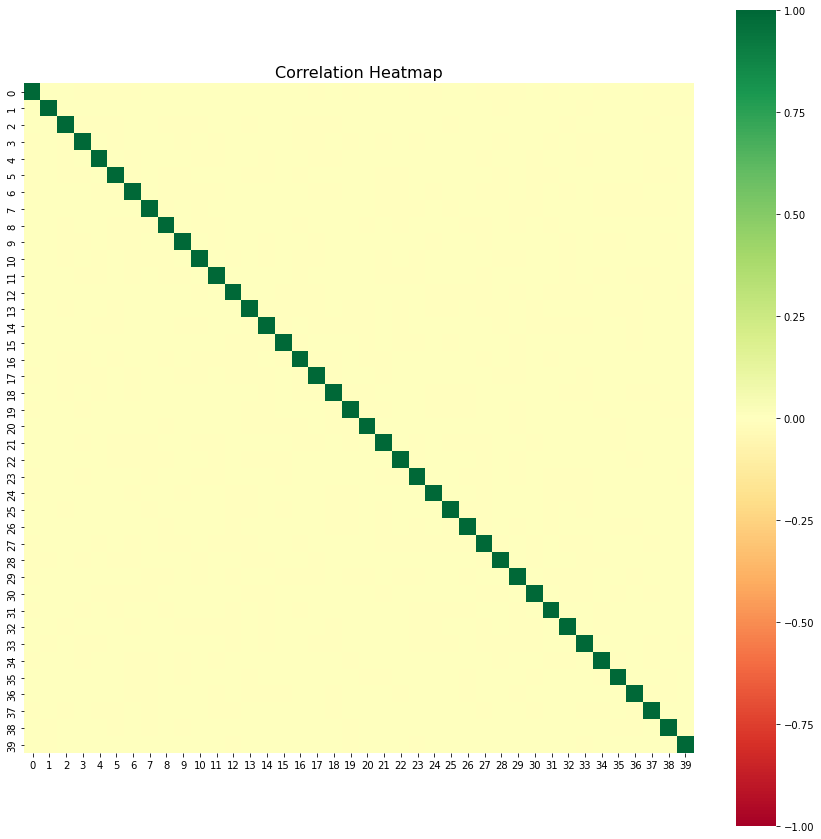

In [ ]:
plt.figure(figsize=(15,15))
corr = pd.DataFrame(X_train_pca).corr()
corr.index = pd.DataFrame(X_train_pca).columns
sns.heatmap(corr, cmap='RdYlGn', vmin=-1, vmax=1, square=True)
plt.title("Correlation Heatmap", fontsize=16)
plt.show()

In [ ]:
#Linear regressor for the raw data
regressor = LinearRegression() 
regressor.fit(X_train,y_train) 

#Linear regressor for the Feature selection group
regressor1 = LinearRegression() 
regressor1.fit(X_train_fs,y_train_fs) 

#Linear regressor for the Feature extraction group
regressor2 = LinearRegression() 
regressor2.fit(X_train_pca,y_train_pca) 
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

LinearRegression(normalize=False)

In [ ]:
#Predict from the test features of raw data
y_pred = regressor.predict(X_test) 

#Predict from the test features of Feature Selection group
y_pred = regressor1.predict(X_test_fs) 

#Predict from the test features of Feature Extraction group
y_pred_pca = regressor2.predict(X_test_pca) 

In [ ]:
#Evaluate the regressor on the raw data
print('RMSE score for the Multiple LR raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred))))
print('Variance score for the Multiple LR raw is : %.2f' % regressor.score(X_test, y_test))
print("\n")

#Evaluate the regressor on the Feature selection group
print('RMSE score for the Multiple LR FS is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred))))
print('Variance score for the Multiple LR FS is : %.2f' % regressor1.score(X_test_fs, y_test_fs))
print("\n")

#Evaluate the regressor on the Feature extraction group
print('RMSE score for the Multiple LR PCA is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca,y_pred_pca))))
print('Variance score for the Multiple LR PCA is : %.2f' % regressor2.score(X_test_pca, y_test_pca))



RMSE score for the Multiple LR raw is : 2731.345474815452
Variance score for the Multiple LR raw is : 0.07


RMSE score for the Multiple LR FS is : 2731.345474815452
Variance score for the Multiple LR FS is : 0.07


RMSE score for the Multiple LR PCA is : 2731.473117220388
Variance score for the Multiple LR PCA is : 0.07


In [ ]:
X_train.shape

(1163048, 46)

In [ ]:
#Find linear correlation of each feature with the target variable
from scipy.stats import pearsonr
df1 = pd.DataFrame(np.concatenate((X_train,y_train.reshape(len(y_train),1)),axis=1))
df1.columns = df1.columns.astype(str)

features = df1.iloc[:,:46].columns.tolist()
target = df1.iloc[:,46].name

correlations = {}
for f in features:
    data_temp = df1[[f,target]]
    x1 = data_temp[f].values
    x2 = data_temp[target].values
    key = f + ' vs ' + target
    correlations[key] = pearsonr(x1,x2)[0]
    
data_correlations = pd.DataFrame(correlations, index=['Value']).T
data_correlations.loc[data_correlations['Value'].abs().sort_values(ascending=False).index]

,Value
0 vs 46,0.18
1 vs 46,-0.05
3 vs 46,0.03
38 vs 46,-0.01
29 vs 46,0.01
20 vs 46,-0.01
30 vs 46,0.01
42 vs 46,0.01
28 vs 46,0.01
4 vs 46,-0.01


In [ ]:
#instantiate the object for the Random Forest Regressor with default params from raw data
regressor_rfraw = RandomForestRegressor(n_jobs=-1)

#instantiate the object for the Random Forest Regressor with default params for Feature Selection Group
regressor_rf = RandomForestRegressor(n_jobs=-1)

# #instantiate the object for the Random Forest Regressor with tuned hyper parameters for Feature Selection Group
# regressor_rf1 = RandomForestRegressor(n_estimators = 26,
#                                      max_depth = 22,
#                                      min_samples_split = 9,
#                                      n_jobs=-1)

#instantiate the object for the Random Forest Regressor for Feature Extraction Group
regressor_rf2 = RandomForestRegressor(n_jobs=-1)


#Train the object with default params for raw data
regressor_rfraw.fit(X_train,y_train)

#Train the object with default params for Feature Selection Group
regressor_rf.fit(X_train_fs,y_train_fs)

# #Train the object with tuned params for Feature Selection Group
# regressor_rf1.fit(X_train_fs,y_train_fs)

# #Train the object with default params for Feature Extraction Group
regressor_rf2.fit(X_train_pca,y_train_pca)

print("\n")

#Predict the output with object of default params for Feature Selection Group
y_pred_rfraw = regressor_rfraw.predict(X_test)

#Predict the output with object of default params for Feature Selection Group
y_pred_rf = regressor_rf.predict(X_test_fs)

# #Predict the output with object of hyper tuned params for Feature Selection Group
# y_pred_rf1 = regressor_rf1.predict(X_test_fs)

#Predict the output with object of PCA params for Feature Extraction Group
y_pred_rfpca = regressor_rf2.predict(X_test_pca)

print("\n")


In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_rfraw))))
print('RMSLE score for the RF regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_rfraw))))
print('Variance score for the RF regressor raw is : %.2f' % regressor_rfraw.score(X_test, y_test))

print("\n")

#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf))))
print('RMSLE score for the RF regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf))))
print('Variance score for the RF regressor is : %.2f' % regressor_rf.score(X_test_fs, y_test_fs))

# print("\n")

# #Evaluate the model with tuned params for Feature Selection Group
# print('RMSE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_rf1))))
# print('RMSLE score for the RF regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_rf1))))
# print('Variance score for the RF regressor1 is : %.2f' % regressor_rf1.score(X_test_fs, y_test_fs))

print("\n")

#Evaluate the model with PCA params  for Feature Extraction Group
print('RMSE score for the RF regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_rfpca))))
print('Variance score for the RF regressor2 is : %.2f' % regressor_rf2.score(X_test_pca, y_test_pca))

In [ ]:
#instantiate the object for the XGBoost Regressor with default params for raw data
regressor_xgbraw = XGBRegressor(n_jobs=-1)

#instantiate the object for the XGBoost Regressor with default params for Feature Selection Group
regressor_xgb = XGBRegressor(n_jobs=-1)

#instantiate the object for the XGBoost Regressor with tuned hyper parameters for Feature Selection Group
regressor_xgb1 = XGBRegressor(n_estimators=300,
                            learning_rate=0.08,
                            gamma=0,
                            subsample=0.75,
                            colsample_bytree=1,
                            max_depth=7,
                            min_child_weight=4,
                            silent=1,
                           n_jobs=-1)

#instantiate the object for the XGBoost Regressor for Feature Extraction Group
regressor_xgb2 = XGBRegressor(n_jobs=-1)


#Train the object with default params for raw data
regressor_xgbraw.fit(X_train,y_train)

#Train the object with default params for Feature Selection Group
regressor_xgb.fit(X_train_fs,y_train_fs)

#Train the object with tuned params for Feature Selection Group
regressor_xgb1.fit(X_train_fs,y_train_fs)

#Train the object with default params for Feature Extraction Group
regressor_xgb2.fit(X_train_pca,y_train_pca)

print("\n")

In [ ]:
#Predict the output with object of default params for raw data
y_pred_xgbraw = regressor_xgbraw.predict(X_test)

#Predict the output with object of default params for Feature Selection Group
y_pred_xgb = regressor_xgb.predict(X_test_fs)

#Predict the output with object of hyper tuned params for Feature Selection Group
y_pred_xgb1 = regressor_xgb1.predict(X_test_fs)

#Predict the output with object of PCA params for Feature Extraction Group
y_pred_xgb_pca = regressor_xgb2.predict(X_test_pca)

print("\n")


In [ ]:
#Evaluate the model with default params for raw data
print('RMSE score for the XGBoost regressor raw is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test,y_pred_xgbraw))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor raw is : %.2f' % regressor_xgbraw.score(X_test, y_test))

print("\n")

#Evaluate the model with default params for Feature Selection Group
print('RMSE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb))))
# print('RMSLE score for the XGBoost regressor is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test,y_pred_xgb))))
print('Variance score for the XGBoost regressor is : %.2f' % regressor_xgb.score(X_test_fs, y_test_fs))

print("\n")

#Evaluate the model with Tuned params for Feature Selection Group
print('RMSE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_fs,y_pred_xgb1))))
# print('RMSLE score for the XGBoost regressor1 is : {}'.format(np.sqrt(metrics.mean_squared_log_error(y_test_fs,y_pred_xgb1))))
print('Variance score for the XGBoost regressor1 is : %.2f' % regressor_xgb1.score(X_test_fs,y_test_fs))

print("\n")

#Evaluate the model with PCA params  for Feature Extraction Group
print('RMSE score for the XGBoost regressor2 is : {}'.format(np.sqrt(metrics.mean_squared_error(y_test_pca, y_pred_xgb_pca))))
print('Variance score for the XGBoost regressor2 is : %.2f' % regressor_xgb2.score(X_test_pca, y_test_pca))

In [ ]:
# displaying the results of evaluation metric values for all models
result=pd.concat([training_df,test_df],keys=['Training set','Test set'])
result